# Day 23: Change Risk Scorer

Use AI to score the risk of a proposed infrastructure or application change before deployment.

**Goal:**
- Input a change description, affected systems, and recent incident history.
- Use an LLM to score risk (Low/Medium/High) and explain the reasoning.
- Visualize risk scores and factors for multiple changes.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set seed for reproducibility
np.random.seed(42)

# Number of synthetic PRs
num_prs = 20
pr_ids = [f"PR_{i+1}" for i in range(num_prs)]

# Generate PR diff data
lines_changed = np.random.randint(10, 501, size=num_prs)
files_changed = np.random.randint(1, 21, size=num_prs)
pr_diff_df = pd.DataFrame({
    "pr_id": pr_ids,
    "lines_changed": lines_changed,
    "files_changed": files_changed
})
pr_diff_df.to_csv("data/pr_diff.csv", index=False)

# Generate coverage data
coverage = np.round(np.random.uniform(40, 100, size=num_prs), 2)
coverage_df = pd.DataFrame({
    "pr_id": pr_ids,
    "coverage": coverage
})
coverage_df.to_csv("data/coverage.csv", index=False)

# Generate deployment history and risk labels
past_failures = np.random.randint(0, 6, size=num_prs)

def classify_risk(lines, cov, failures):
    if lines > 300 and cov < 60 and failures > 2:
        return "High"
    elif lines > 150 or cov < 70 or failures > 1:
        return "Medium"
    else:
        return "Low"

risk_labels = [
    classify_risk(lines_changed[i], coverage[i], past_failures[i])
    for i in range(num_prs)
]

deploy_df = pd.DataFrame({
    "pr_id": pr_ids,
    "past_failures": past_failures,
    "risk_label": risk_labels
})
deploy_df.to_csv("data/deploy.csv", index=False)

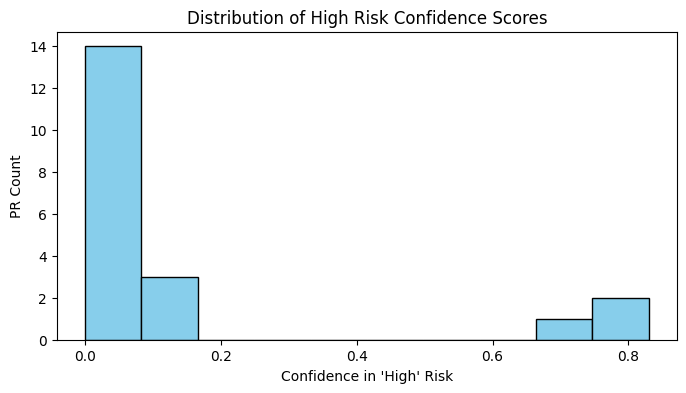

,pr_id,predicted_risk,risk_score,explanation
0,PR_1,Medium,0.100000,"Risk Level: Medium (0.10 confidence) • Lines changed: 112 • Test coverage: 43.9% • Deployment history: 1 failures ⚠️ Moderate risk due to either size, coverage, or past failures."
1,PR_2,Medium,0.030000,"Risk Level: Medium (0.03 confidence) • Lines changed: 445 • Test coverage: 96.93% • Deployment history: 1 failures ⚠️ Moderate risk due to either size, coverage, or past failures."
2,PR_3,Medium,0.120000,"Risk Level: Medium (0.12 confidence) • Lines changed: 358 • Test coverage: 97.94% • Deployment history: 5 failures ⚠️ Moderate risk due to either size, coverage, or past failures."
3,PR_4,Medium,0.040000,"Risk Level: Medium (0.04 confidence) • Lines changed: 280 • Test coverage: 88.5% • Deployment history: 3 failures ⚠️ Moderate risk due to either size, coverage, or past failures."
4,PR_5,Medium,0.060000,"Risk Level: Medium (0.06 confidence) • Lines changed: 116 • Test coverage: 58.28% • Deployment history: 5 failures ⚠️ Moderate risk due to either size, coverage, or past failures."


In [8]:
# Load data
from data_loader import load_pr_diff, load_test_coverage, load_deployment_history, merge_features
from risk_classifier import RiskScorer
from llm_explainer import explain_risk

pr_df = load_pr_diff("data/pr_diff.csv")
coverage_df = load_test_coverage("data/coverage.csv")
deploy_df = load_deployment_history("data/deploy.csv")

features_df = merge_features(pr_df, coverage_df, deploy_df)

# Train model
X = features_df[["lines_changed", "coverage", "past_failures"]]
y = features_df["risk_label"]

scorer = RiskScorer()
scorer.train(X, y)

# Predict and explain
features_df["predicted_risk"] = scorer.predict(X)

# Get numeric risk score (probability of "High" risk)
proba = scorer.predict_proba(X)
high_index = list(scorer.encoder.classes_).index("High")
features_df["risk_score"] = proba[:, high_index]  # Confidence in "High" risk

# Add explanation
features_df["explanation"] = features_df.apply(
    lambda row: explain_risk(row, row["predicted_risk"], row["risk_score"]),
    axis=1
)


plt.figure(figsize=(8, 4))
plt.hist(features_df["risk_score"], bins=10, color="skyblue", edgecolor="black")
plt.title("Distribution of High Risk Confidence Scores")
plt.xlabel("Confidence in 'High' Risk")
plt.ylabel("PR Count")
plt.show()

features_df.to_csv("data/predicted_risks_with_explanations.csv", index=False)

features_df[["pr_id", "predicted_risk", "risk_score", "explanation"]].head(5).style.set_properties(**{
    'white-space': 'pre-wrap'
})




In [21]:
%pip install pdfkit

import pandas as pd
import matplotlib.pyplot as plt
import pdfkit

# Load your formatted DataFrame
df = pd.read_csv("data/predicted_risks_with_explanations.csv")

# Clean explanation column to avoid rendering issues
df["explanation"] = df["explanation"].str.replace("⚠️", "[Warning]").str.replace("•", "-")

# Define a function to highlight predicted risk
def highlight_risk(val):
    colors = {
        "High": "background-color: #ffcccc",
        "Medium": "background-color: #fff2cc",
        "Low": "background-color: #ccffcc"
    }
    return colors.get(val, "")

# Apply styling
styled_df = df.style.map(highlight_risk, subset=["predicted_risk"]).set_properties(**{
    'white-space': 'pre-wrap',
    'text-align': 'left',
    'font-family': 'Arial',
    'font-size': '12px'
}).set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#f2f2f2'), ('font-weight', 'bold'), ('padding', '8px')]},
    {'selector': 'td', 'props': [('padding', '8px'), ('border', '1px solid #ddd')]},
    {'selector': 'td:nth-child(10)', 'props': [('min-width', '400px'), ('max-width', '600px')]}  # explanation column
])

# Convert styled DataFrame to HTML
table_html = styled_df.to_html()

# Wrap in full HTML document
styled_html = f"""
<!DOCTYPE html>
<html>
<head>
    <meta charset="UTF-8">
    <style>
        body {{
            font-family: Arial, sans-serif;
            font-size: 12px;
            padding: 20px;
        }}
        table {{
            border-collapse: collapse;
            width: 100%;
        }}
        th, td {{
            border: 1px solid #ddd;
            padding: 8px;
            text-align: left;
            white-space: pre-wrap;
        }}
        th {{
            background-color: #f2f2f2;
            font-weight: bold;
        }}
        td:nth-child(10) {{
            min-width: 400px;
            max-width: 600px;
        }}
    </style>
</head>
<body>
<h2>Predicted Risks with Explanations</h2>
{table_html}
</body>
</html>
"""

# Save styled HTML
html_path = "data/predicted_risks_with_explanations.html"
pdf_path = "data/predicted_risks_with_explanations.pdf"

with open(html_path, "w", encoding="utf-8") as f:
    f.write(styled_html)

# Convert HTML to PDF using pdfkit
pdfkit.from_file(html_path, pdf_path, options={"quiet": "", "encoding": "UTF-8"})

Note: you may need to restart the kernel to use updated packages.


True